## Plan
My plan is to find out a category with the large number of reviews per business and the low average rating. This kind of category is what people often use but are not usually satisfied with. Therefore, a new business which improves on the points where people have complaints is likely to succeed.  

In [1]:
import pandas as pd

business_data = pd.read_csv('../data-sets/yelp_academic_dataset_business.csv')
review_data = pd.read_csv('../data-sets/yelp_academic_dataset_review.csv')
user_data = pd.read_csv('../data-sets/yelp_academic_dataset_user.csv')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

In [3]:
# Treating missing values
missing_value = business_data.isnull().sum() / business_data.shape[0]
business_data = business_data.drop(columns = list(missing_value[missing_value == 1].index))
business_data.columns = business_data.columns.str.lower().str.replace('.', '_')

In [4]:
# Remove unnecessary columns
filt = business_data.columns.str.startswith('attributes_')
business_data = business_data.drop(columns = business_data.columns[filt])

In [5]:
# Remove hours.* columns
filt = business_data.columns.str.startswith('hours_')
business_data = business_data.drop(columns = business_data.columns[filt])

In [6]:
# Leave only the businesses in the USA
us_data = pd.read_csv('../data-sets/territory_abbr.csv')
us_data = us_data['Abbreviation']
us_data = us_data.rename('state')
business_data_usa = business_data.merge(us_data, 
                           how = 'inner', 
                           on = 'state')

I will only analyze the data in the USA.

## Review counts per category

In [7]:
sub_business = business_data_usa[['business_id','name','categories','state']]
merged = review_data.merge(sub_business, how = 'inner', on = 'business_id')

In [8]:
nrow = business_data_usa.shape[0]
ctg = []
for i in range(nrow):
    ctg.append(str(business_data_usa['categories'][i]).split(", "))
ctg2 = [y for x in ctg for y in x]


In [9]:
a = []
length = len(ctg)
count = business_data_usa['review_count']

for i in range(length):
    a.append([count[i]] * len(ctg[i]))

a2 = [y for x in a for y in x]

In [10]:
data = {'categories': ctg2, 'count': a2}
ctg_count = pd.DataFrame(data)

review_count = ctg_count.groupby('categories')['count'].sum().sort_values(ascending = False)

## Average rating per category

In [11]:
nrow = merged.shape[0]
ctg_merged = merged['categories']
ctg = []
for i in range(nrow):
    ctg.append(str(ctg_merged[i]).split(", "))
ctg2 = [y for x in ctg for y in x]

In [12]:
a = []
length = len(ctg)
stars = merged['stars']

for i in range(length):
    a.append([stars[i]] * len(ctg[i]))

a2 = [y for x in a for y in x]

In [13]:
data = {'categories': ctg2, 'stars': a2}

In [14]:
ctg_stars = pd.DataFrame(data)

In [15]:
average_star = ctg_stars.groupby('categories')['stars'].mean().sort_values(ascending = False)
dat = pd.concat([review_count, average_star, ctg_count['categories'].value_counts(), ctg_count.groupby('categories')['count'].mean()], axis=1)

In [16]:
dat.columns = ['count','stars','stores','count mean']
dat

,count,stars,stores,count mean
Restaurants,2957256,3.739261,34189,86.497294
Food,934238,3.857778,17263,54.117940
Nightlife,863329,3.712945,8454,102.120771
Bars,795249,3.713260,7320,108.640574
American (New),574478,3.781616,3913,146.812676
...,...,...,...,...
Surf Schools,3,2.333333,1,3.000000
Entertainment Law,3,5.000000,1,3.000000
Carousels,3,3.666667,1,3.000000
Playsets,3,2.333333,1,3.000000


In [17]:
filt1 = dat['stars'] < 2.5
filt2 = dat['stores'] > 50
dat[filt1 & filt2].sort_values(by = 'count mean', ascending = False)

,count,stars,stores,count mean
Airlines,7209,2.144304,98,73.561224
Television Service Providers,5308,1.926861,182,29.164835
Internet Service Providers,8698,2.065892,391,22.245524
Utilities,1892,2.159175,86,22.000000


The category which has the most reviews per business when the average rating is less than 2.5 is airlines.

<AxesSubplot:title={'center':'Histogram of Ratings of Airlines'}, ylabel='Frequency'>

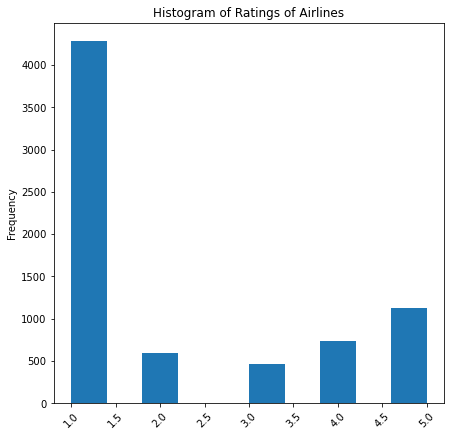

In [18]:
merged_air = merged[merged['categories'].str.contains('Airlines').fillna(False)]
merged_air['stars'].plot(kind = 'hist',
                        title = 'Histogram of Ratings of Airlines',
                        rot = 45,
                        figsize = (7, 7)
                        )

<AxesSubplot:title={'center':'Histogram of Ratings of Television Service Providers'}, ylabel='Frequency'>

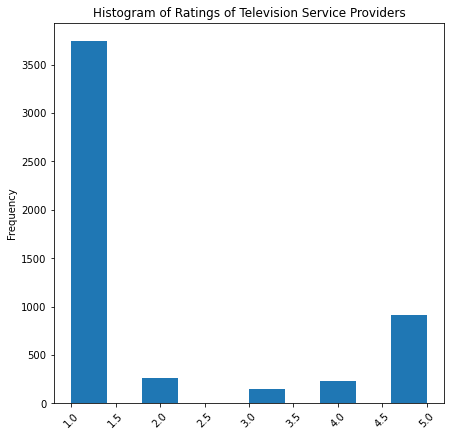

In [19]:
merged_tv = merged[merged['categories'].str.contains('Television Service Providers').fillna(False)]
merged_tv['stars'].plot(kind = 'hist',
                        title = 'Histogram of Ratings of Television Service Providers',
                        rot = 45,
                        figsize = (7, 7)
                        )

## Review counts over time per category

<AxesSubplot:title={'center':'Annual Review Count of Airlines'}, xlabel='date'>

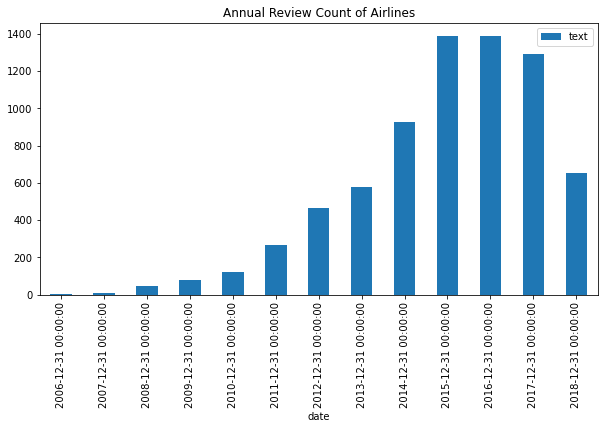

In [20]:
# 'Airlines'

filt2 = merged['categories'].str.contains('Airlines')
filt2[filt2.isnull()] = False
merged_air = merged[filt2].set_index(pd.DatetimeIndex(merged[filt2]['date']))
by_year2 = merged_air.resample('A').agg({'text':'count'})
by_year2.plot(kind = 'bar',
          figsize = (10, 5), title = 'Annual Review Count of Airlines')

<AxesSubplot:title={'center':'Annual Average Rating of Airlines'}, xlabel='date'>

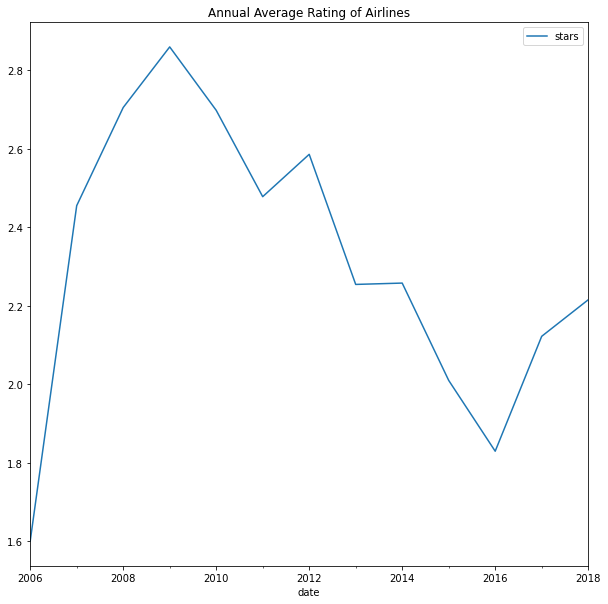

In [21]:
by_year2 = merged_air.resample('A').agg({'stars':'mean'})
by_year2.plot(figsize = (10, 10), title = 'Annual Average Rating of Airlines')

However, the annual review counts of airlines has decreased and the annual average rating has increased since 2016.

<AxesSubplot:title={'center':'Annual Review Count of Television Service Providers'}, xlabel='date'>

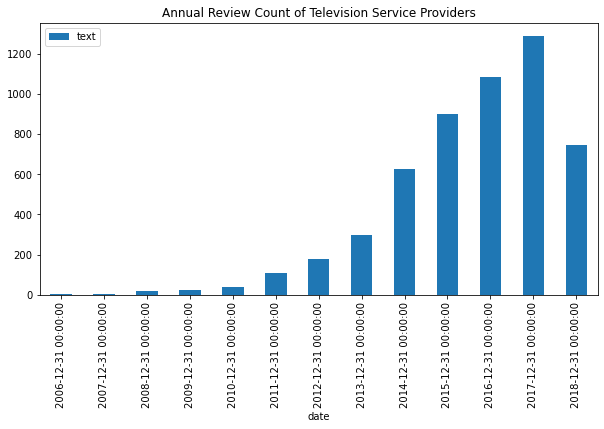

In [22]:
# 'Television Service Providers'

filt2 = merged['categories'].str.contains('Television Service Providers')
filt2[filt2.isnull()] = False
merged_tv = merged[filt2].set_index(pd.DatetimeIndex(merged[filt2]['date']))
by_year2 = merged_tv.resample('A').agg({'text':'count'})
by_year2.plot(kind = 'bar',
          figsize = (10, 5), title = 'Annual Review Count of Television Service Providers')

<AxesSubplot:title={'center':'Annual Average Rating of Television Service Providers'}, xlabel='date'>

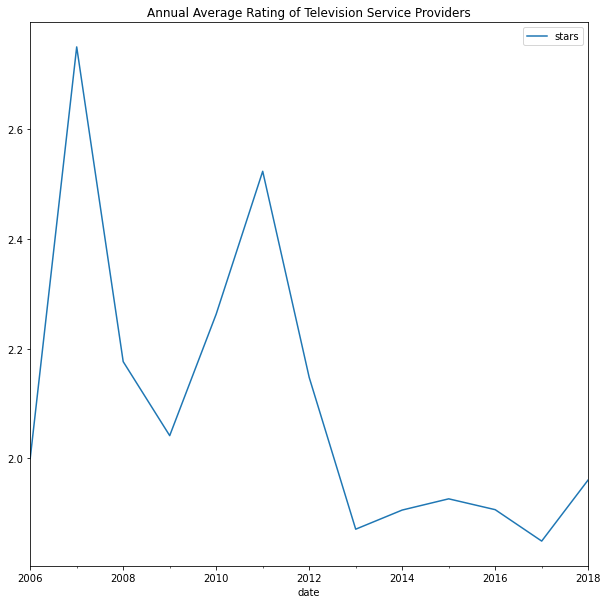

In [23]:
by_year2 = merged_tv.resample('A').agg({'stars':'mean'})
by_year2.plot(figsize = (10, 10), title = 'Annual Average Rating of Television Service Providers')

In contrast, the annual review counts of television service providers keeps increasing (the data in 2018 is incomplete.) and there is no significant change in the low annual average rating.

## Average rating per business

In [34]:
id_tv = pd.concat([merged_tv.groupby('business_id')['stars'].mean(), merged_tv.groupby('business_id')['stars'].count()], axis=1)
id_tv.columns = ['average stars', 'counts']

tv_business = id_tv.sort_values(by = 'counts', ascending = False).merge(business_data_usa, how = 'inner', on = 'business_id')
tv_business.set_index('name', inplace= True)

## Counterargument: What if not many television service providers have low ratings, but only certain stores significantly lower the average rating?

<AxesSubplot:title={'center':'Histogram of Average Ratings per Business'}, ylabel='Frequency'>

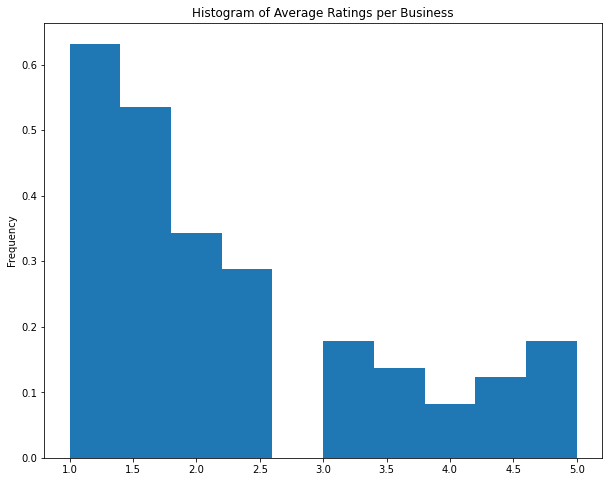

In [25]:
tv_business['stars'].plot(
    kind = 'hist', 
    title = 'Histogram of Average Ratings per Business',
    figsize = (10, 8), density = True)

In [26]:
tv_business['state'].value_counts()

AZ    71
NV    51
NC    23
OH    16
WI     9
PA     9
IL     3
Name: state, dtype: int64

<AxesSubplot:title={'center':'Histogram of Average Ratings per Business in Arizona'}, ylabel='Frequency'>

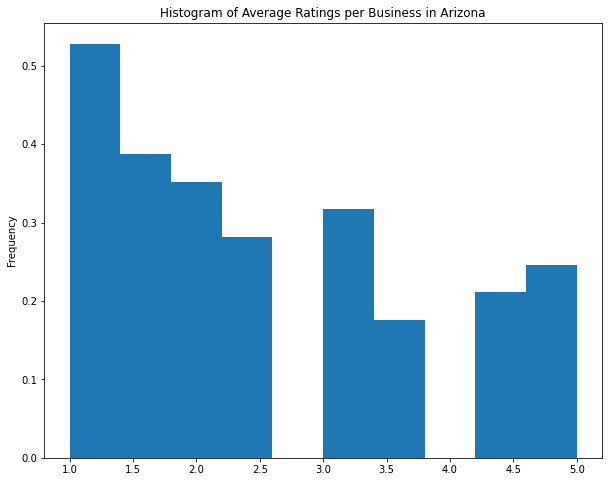

In [27]:
tv_business[tv_business['state'] == 'AZ']['stars'].plot(
    kind = 'hist', 
    title = 'Histogram of Average Ratings per Business in Arizona',
    figsize = (10, 8), density = True)

<AxesSubplot:title={'center':'Histogram of Average Ratings per Business in Nevada'}, ylabel='Frequency'>

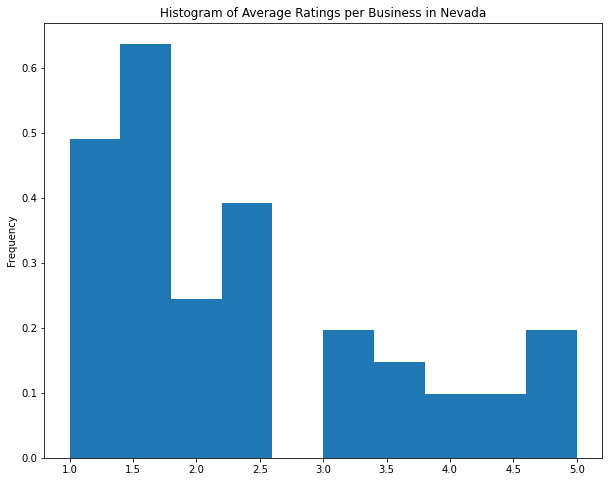

In [28]:
tv_business[tv_business['state'] == 'NV']['stars'].plot(
    kind = 'hist', 
    title = 'Histogram of Average Ratings per Business in Nevada',
    figsize = (10, 8), density = True)

In [29]:
(tv_business['stars'] < 3).sum() / tv_business.shape[0]

0.7197802197802198

In [30]:
# The function to compute the rate of low ratings
def low_rate(x):
    return (x['stars'] < 3).sum() / x.shape[0]

In [31]:
print(low_rate(tv_business))
print(low_rate(tv_business[tv_business['state'] == 'AZ']))
print(low_rate(tv_business[tv_business['state'] == 'NV']))

0.7197802197802198
0.6197183098591549
0.7058823529411765


There is difference across states, however, it is obvious that majority of TV service providers have low ratings. 72% of businesses have ratings lower than 3.

## Reviews of TV Service Providers

In [32]:
review = merged_tv.sort_values(by = 'useful', ascending = False)['text'].str.lower().str.split(" ")
words = [y for x in review for y in x]
import string
words = [''.join(c for c in s if c not in string.punctuation) for s in words]
words = [s for s in words if s]
# pd.Series(words).value_counts().to_csv("words.csv")

In [33]:
# merged_tv.sort_values(by = 'useful', ascending = False)['text'].to_csv("review.csv")

I looked at the reviews of TV service providers to understand which complaints customers have.